In [63]:
import pandas as pd

# 1. Завантаження даних
df = pd.read_csv("online_retail.csv")
df_copy = df.copy()

print(df_copy.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

           InvoiceDate  UnitPrice  CustomerID         Country  
0  2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2  2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4  2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [64]:
# 2. Підготуйте дані
# Видалимо рядки з відсутнім CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

# Видалимо скасовані транзакції (InvoiceNo з 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Видалимо негативну кількість
df = df[df['Quantity'] > 0]

# Залишимо лише транзакції з Великобританії (можна змінити)
df = df[df['Country'] == 'United Kingdom']

# Приведемо до типу string
df['InvoiceNo'] = df['InvoiceNo'].astype(str)

In [65]:
# 3. На основні власних даних з застосуванням алгоритму apriori сформувати набір асоціативних правил.
from mlxtend.frequent_patterns import apriori, association_rules

# Побудова корзин (інвойсів)
basket = (
    df.groupby(['InvoiceNo', 'Description'])['Quantity']
    .sum()
    .unstack()
    .fillna(0)
    .gt(0)
    .astype(bool)
)

# Часті набори товарів
frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)

# Створення правил
rules_ap = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

# Вивід найсильніших правил
print(rules_ap[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='confidence', ascending=False).head(10))


                                          antecedents  \
70  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
71  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
4                    (PINK REGENCY TEACUP AND SAUCER)   
7                   (GREEN REGENCY TEACUP AND SAUCER)   
62                   (PINK REGENCY TEACUP AND SAUCER)   
3                (GARDENERS KNEELING PAD CUP OF TEA )   
72  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
6                  (ROSES REGENCY TEACUP AND SAUCER )   
73                   (PINK REGENCY TEACUP AND SAUCER)   
64                 (RED HANGING HEART T-LIGHT HOLDER)   

                                          consequents   support  confidence  \
70                  (GREEN REGENCY TEACUP AND SAUCER)  0.020482    0.890339   
71                 (ROSES REGENCY TEACUP AND SAUCER )  0.020482    0.844059   
4                   (GREEN REGENCY TEACUP AND SAUCER)  0.024266    0.819473   
7                  (ROSES REGENCY TEACUP AND SAUCER )  0

In [66]:
# 4. На основні власних даних з застосуванням алгоритму FP-growth сформувати набір асоціативних правил.
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Побудова корзин (інвойсів)
basket = (
    df.groupby(['InvoiceNo', 'Description'])['Quantity']
    .sum()
    .unstack()
    .fillna(0)
    .gt(0)    
    .astype(bool)  # Перетворення на бульові значення
)

# Часті набори товарів за допомогою FP-growth
frequent_itemsets_fp = fpgrowth(basket, min_support=0.02, use_colnames=True)

# Створення асоціативних правил
rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=1.0)

# Виведення найсильніших правил
print(rules_fp[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False).head(10))


                                          antecedents  \
54  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...   
59                  (GREEN REGENCY TEACUP AND SAUCER)   
57                   (PINK REGENCY TEACUP AND SAUCER)   
56  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...   
51                  (GREEN REGENCY TEACUP AND SAUCER)   
50                   (PINK REGENCY TEACUP AND SAUCER)   
58                 (ROSES REGENCY TEACUP AND SAUCER )   
55  (PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
48                 (ROSES REGENCY TEACUP AND SAUCER )   
49                  (GREEN REGENCY TEACUP AND SAUCER)   

                                          consequents   support  confidence  \
54                  (GREEN REGENCY TEACUP AND SAUCER)  0.020482    0.890339   
59  (PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...  0.020482    0.557190   
57  (ROSES REGENCY TEACUP AND SAUCER , GREEN REGEN...  0.020482    0.691684   
56                   (PINK REGENCY TEACUP AND SAUCER)  0

In [68]:
# 5. На основні власних даних з застосуванням алгоритму eclat сформувати набір асоціативних правил.
from itertools import combinations

# Очищення назв товарів
df['Description'] = df['Description'].str.strip()

# Побудова вертикального представлення (ECLAT)
vertical_data = {}
transactions = df.groupby('InvoiceNo')['Description'].apply(set)

for tid, items in transactions.items():
    for item in items:
        vertical_data.setdefault(item, set()).add(tid)

min_support = 0.02
min_confidence = 0.5
min_lift = 1.0
transaction_count = len(transactions)

# Обчислення частих наборів
def eclat(prefix, items, frequent_itemsets):
    while items:
        item, tids = items.pop()
        new_prefix = prefix + [item]
        support = len(tids) / transaction_count
        if support >= min_support:
            frequent_itemsets[frozenset(new_prefix)] = tids
            # Перетин транзакцій для розширення
            suffix = []
            for other_item, other_tids in items:
                tids_intersection = tids & other_tids
                if len(tids_intersection) / transaction_count >= min_support:
                    suffix.append((other_item, tids_intersection))
            eclat(new_prefix, suffix, frequent_itemsets)

# Підготовка та запуск
items = sorted(vertical_data.items())
frequent_itemsets = {}
eclat([], items.copy(), frequent_itemsets)

# Побудова асоціативних правил
rules = []
for itemset in frequent_itemsets:
    if len(itemset) >= 2:
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent
                support = len(frequent_itemsets[itemset]) / transaction_count
                confidence = support / (len(frequent_itemsets[antecedent]) / transaction_count)
                lift = confidence / (len(frequent_itemsets[consequent]) / transaction_count)
                if confidence >= min_confidence and lift >= min_lift:
                    rules.append({
                        'antecedent': ', '.join(antecedent),
                        'consequent': ', '.join(consequent),
                        'support': round(support, 4),
                        'confidence': round(confidence, 4),
                        'lift': round(lift, 4)
                    })

# Виведення результатів
rules_elc = pd.DataFrame(rules)
rules_elc = rules_elc.sort_values(by='lift', ascending=False)
print(rules_df.head(10))


                                           antecedent  \
8                     GREEN REGENCY TEACUP AND SAUCER   
9   ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY ...   
7                      PINK REGENCY TEACUP AND SAUCER   
10  ROSES REGENCY TEACUP AND SAUCER, GREEN REGENCY...   
15                    GREEN REGENCY TEACUP AND SAUCER   
14                     PINK REGENCY TEACUP AND SAUCER   
6                     ROSES REGENCY TEACUP AND SAUCER   
11  PINK REGENCY TEACUP AND SAUCER, GREEN REGENCY ...   
12                    ROSES REGENCY TEACUP AND SAUCER   
13                    GREEN REGENCY TEACUP AND SAUCER   

                                           consequent  support  confidence  \
8   ROSES REGENCY TEACUP AND SAUCER, PINK REGENCY ...   0.0205      0.5572   
9                     GREEN REGENCY TEACUP AND SAUCER   0.0205      0.8903   
7   ROSES REGENCY TEACUP AND SAUCER, GREEN REGENCY...   0.0205      0.6917   
10                     PINK REGENCY TEACUP AND SAUCER   0.02

In [69]:
# 6. Оцінити показники якості створених наборів правил та порівняти ресурси витрачені на їх формування.
from memory_profiler import memory_usage
import time

def measure_resources(func):
    start_time = time.time()
    mem_usage = memory_usage((func,))

    execution_time = time.time() - start_time
    mem_usage_max = max(mem_usage)  # Максимальне використання пам'яті в мегабайтах

    return execution_time, mem_usage_max

def run_apriori():
    from mlxtend.frequent_patterns import apriori, association_rules
    basket = (
        df.groupby(['InvoiceNo', 'Description'])['Quantity']
        .sum()
        .unstack()
        .fillna(0)
        .gt(0)
        .astype(bool)
    )
    frequent_itemsets = apriori(basket, min_support=0.02, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    return rules

execution_time_apriori, memory_usage_apriori = measure_resources(run_apriori)
print(f"Apriori - Time: {execution_time_apriori:.4f} seconds, Memory: {memory_usage_apriori:.4f} MB")

def run_fpgrowth():
    from mlxtend.frequent_patterns import fpgrowth, association_rules
    basket = (
        df.groupby(['InvoiceNo', 'Description'])['Quantity']
        .sum()
        .unstack()
        .fillna(0)
        .gt(0)
        .astype(bool)
    )
    frequent_itemsets = fpgrowth(basket, min_support=0.02, use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
    return rules
    
execution_time_fpgrowth, memory_usage_fpgrowth = measure_resources(run_fpgrowth)
print(f"FP-growth - Time: {execution_time_fpgrowth:.4f} seconds, Memory: {memory_usage_fpgrowth:.4f} MB")

def run_eclat():
    from itertools import combinations
    df['Description'] = df['Description'].str.strip()
    vertical_data = {}
    transactions = df.groupby('InvoiceNo')['Description'].apply(set)
    transaction_count = len(transactions)
    
    for tid, items in transactions.items():
        for item in items:
            vertical_data.setdefault(item, set()).add(tid)
    
    min_support = 0.02
    min_confidence = 0.5
    min_lift = 1.0

    def eclat(prefix, items, frequent_itemsets):
        while items:
            item, tids = items.pop()
            new_prefix = prefix + [item]
            support = len(tids) / transaction_count
            if support >= min_support:
                frequent_itemsets[frozenset(new_prefix)] = tids
                suffix = []
                for other_item, other_tids in items:
                    tids_intersection = tids & other_tids
                    if len(tids_intersection) / transaction_count >= min_support:
                        suffix.append((other_item, tids_intersection))
                eclat(new_prefix, suffix, frequent_itemsets)

    # Перетворюємо елементи на рядки перед сортуванням
    items = sorted(vertical_data.items(), key=lambda x: str(x[0]))  # Перетворюємо на рядок
    frequent_itemsets = {}
    eclat([], items.copy(), frequent_itemsets)

    rules = []
    for itemset in frequent_itemsets:
        if len(itemset) >= 2:
            for i in range(1, len(itemset)):
                for antecedent in combinations(itemset, i):
                    antecedent = frozenset(antecedent)
                    consequent = itemset - antecedent
                    support = len(frequent_itemsets[itemset]) / transaction_count
                    confidence = support / (len(frequent_itemsets[antecedent]) / transaction_count)
                    lift = confidence / (len(frequent_itemsets[consequent]) / transaction_count)
                    if confidence >= min_confidence and lift >= min_lift:
                        rules.append({
                            'antecedent': ', '.join(antecedent),
                            'consequent': ', '.join(consequent),
                            'support': round(support, 4),
                            'confidence': round(confidence, 4),
                            'lift': round(lift, 4)
                        })

    return pd.DataFrame(rules)

execution_time_eclat, memory_usage_eclat = measure_resources(run_eclat)
print(f"ECLAT - Time: {execution_time_eclat:.4f} seconds, Memory: {memory_usage_eclat:.4f} MB")





Apriori - Time: 2.8464 seconds, Memory: 1660.9414 MB
FP-growth - Time: 6.3627 seconds, Memory: 1877.5352 MB
ECLAT - Time: 2.1139 seconds, Memory: 563.1953 MB


In [73]:
def remove_redundant_rules(rules_df):
    """
    Функція для видалення надлишкових правил.
    Правила вважаються надлишковими, якщо їхні ліві та праві частини є підмножинами інших правил.
    """
    non_redundant_rules = []

    for _, rule in rules_df.iterrows():
        redundant = False
        # Перевірка кожного правила на наявність підмножин серед уже оброблених правил
        for nr_rule in non_redundant_rules:
            # Для Apriori та FP-growth (де antecedents і consequents є frozenset)
            if 'antecedents' in rule and 'consequents' in rule:
                antecedent = set(rule['antecedents'])
                consequent = set(rule['consequents'])
                antecedent_nr = set(nr_rule['antecedents'])
                consequent_nr = set(nr_rule['consequents'])
            # Для ECLAT
            elif 'antecedent' in rule and 'consequent' in rule:
                antecedent = set(rule['antecedent'].split(', '))
                consequent = set(rule['consequent'].split(', '))
                antecedent_nr = set(nr_rule['antecedent'].split(', '))
                consequent_nr = set(nr_rule['consequent'].split(', '))

            # Перевірка на підмножину
            if (antecedent <= antecedent_nr and consequent <= consequent_nr):
                redundant = True
                break
        if not redundant:
            non_redundant_rules.append(rule)

    # Повертаємо DataFrame без надлишкових правил
    return pd.DataFrame(non_redundant_rules)

# Проганяємо фільтрацію для результатів Apriori, FP-growth та ECLAT
filtered_rules_apriori = remove_redundant_rules(rules_ap)
filtered_rules_fp = remove_redundant_rules(rules_fp)
filtered_rules_eclat = remove_redundant_rules(rules_elc)

# Виведення результатів після фільтрації
print("Filtered Apriori Rules:")
print(filtered_rules_apriori.head(10))

print("Filtered FP-growth Rules:")
print(filtered_rules_fp.head(10))

print("Filtered ECLAT Rules:")
print(filtered_rules_eclat.head(10))


Filtered Apriori Rules:
                            antecedents                           consequents  \
0           (ALARM CLOCK BAKELIKE RED )          (ALARM CLOCK BAKELIKE GREEN)   
1          (ALARM CLOCK BAKELIKE GREEN)           (ALARM CLOCK BAKELIKE RED )   
2   (GARDENERS KNEELING PAD KEEP CALM )  (GARDENERS KNEELING PAD CUP OF TEA )   
3  (GARDENERS KNEELING PAD CUP OF TEA )   (GARDENERS KNEELING PAD KEEP CALM )   
4      (PINK REGENCY TEACUP AND SAUCER)     (GREEN REGENCY TEACUP AND SAUCER)   
5     (GREEN REGENCY TEACUP AND SAUCER)      (PINK REGENCY TEACUP AND SAUCER)   
6    (ROSES REGENCY TEACUP AND SAUCER )     (GREEN REGENCY TEACUP AND SAUCER)   
7     (GREEN REGENCY TEACUP AND SAUCER)    (ROSES REGENCY TEACUP AND SAUCER )   
8               (HEART OF WICKER SMALL)               (HEART OF WICKER LARGE)   
9               (HEART OF WICKER LARGE)               (HEART OF WICKER SMALL)   

   antecedent support  consequent support   support  confidence       lift  \
0     

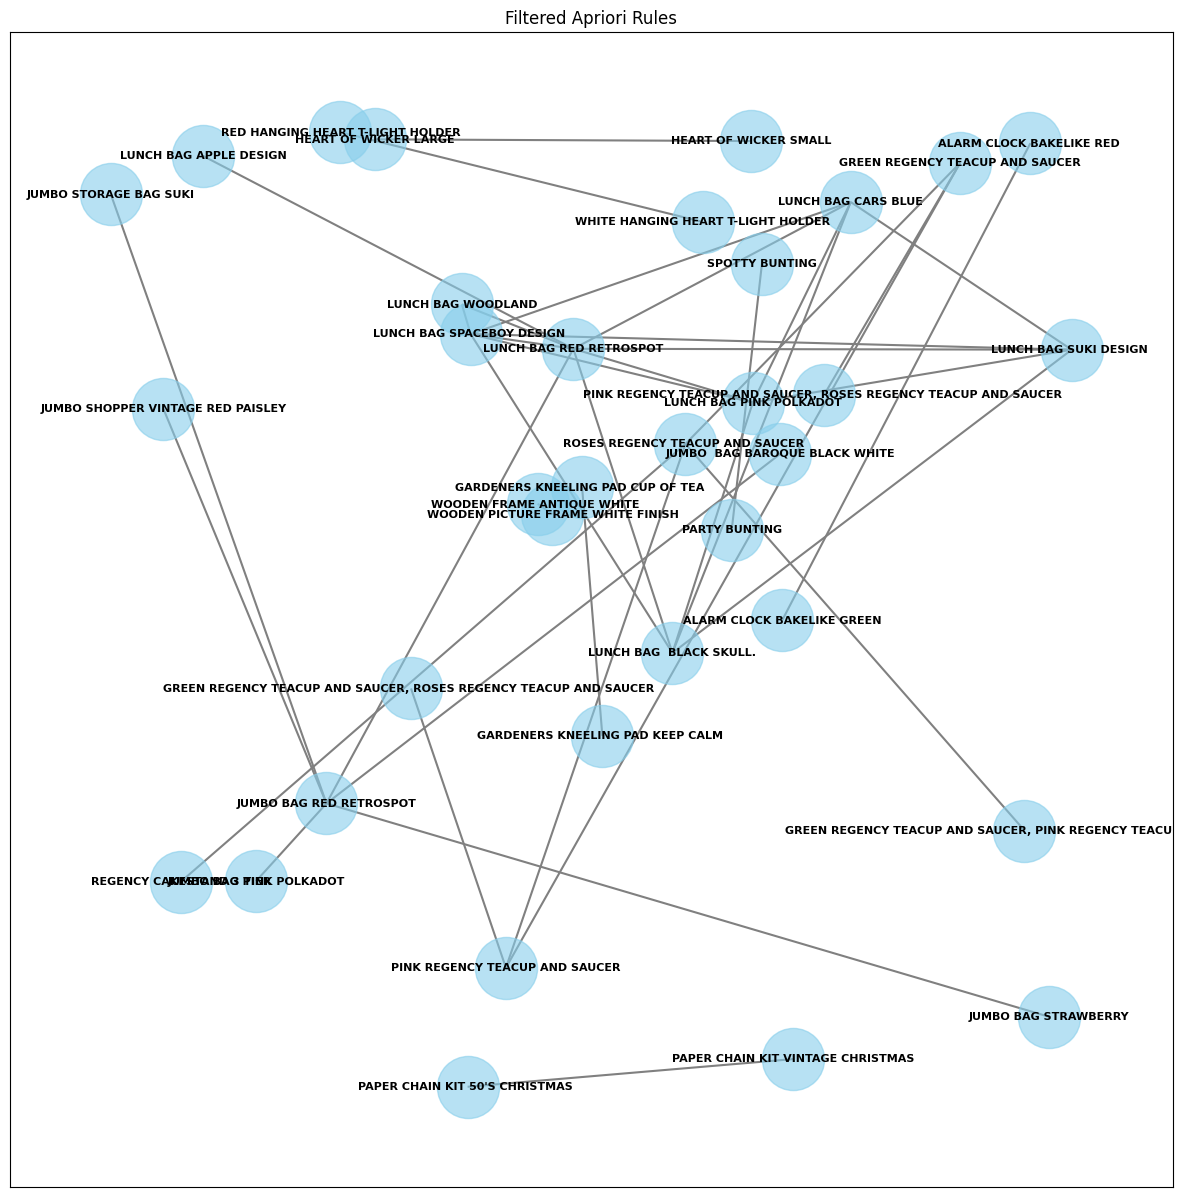

In [89]:
import networkx as nx
import matplotlib.pyplot as plt

# Використовуємо дані правил Apriori
rules_df = filtered_rules_apriori  # Припускаємо, що ви вже маєте ці дані після фільтрації

# Створюємо порожній граф
G = nx.Graph()

# Додаємо вузли і з'єднання для кожного правила
for _, rule in rules_df.iterrows():
    antecedent = ', '.join(sorted(rule['antecedents'])) if isinstance(rule['antecedents'], frozenset) else rule['antecedents']
    consequent = ', '.join(sorted(rule['consequents'])) if isinstance(rule['consequents'], frozenset) else rule['consequents']
    
    # Додаємо з'єднання між antecedent та consequent
    G.add_edge(antecedent, consequent, weight=rule['lift'])  # Вага з'єднання - це lift

# Налаштовуємо візуалізацію з покращеним розташуванням
plt.figure(figsize=(15, 15))  # Збільшуємо розмір графіка для кращої видимості
pos = nx.spring_layout(G, k=0.005, iterations=1)  # Зменшуємо k для більшого простору між вузлами
edges = G.edges(data=True)

# Рисуємо граф з покращеними параметрами
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="skyblue", alpha=0.6)
nx.draw_networkx_edges(G, pos, width=1.5, edge_color='gray')  # Тонші лінії
nx.draw_networkx_labels(G, pos, font_size=8, font_weight="bold")

# Заголовок
plt.title("Filtered Apriori Rules")
# plt.axis("off")  # Вимикаємо осі
plt.show()


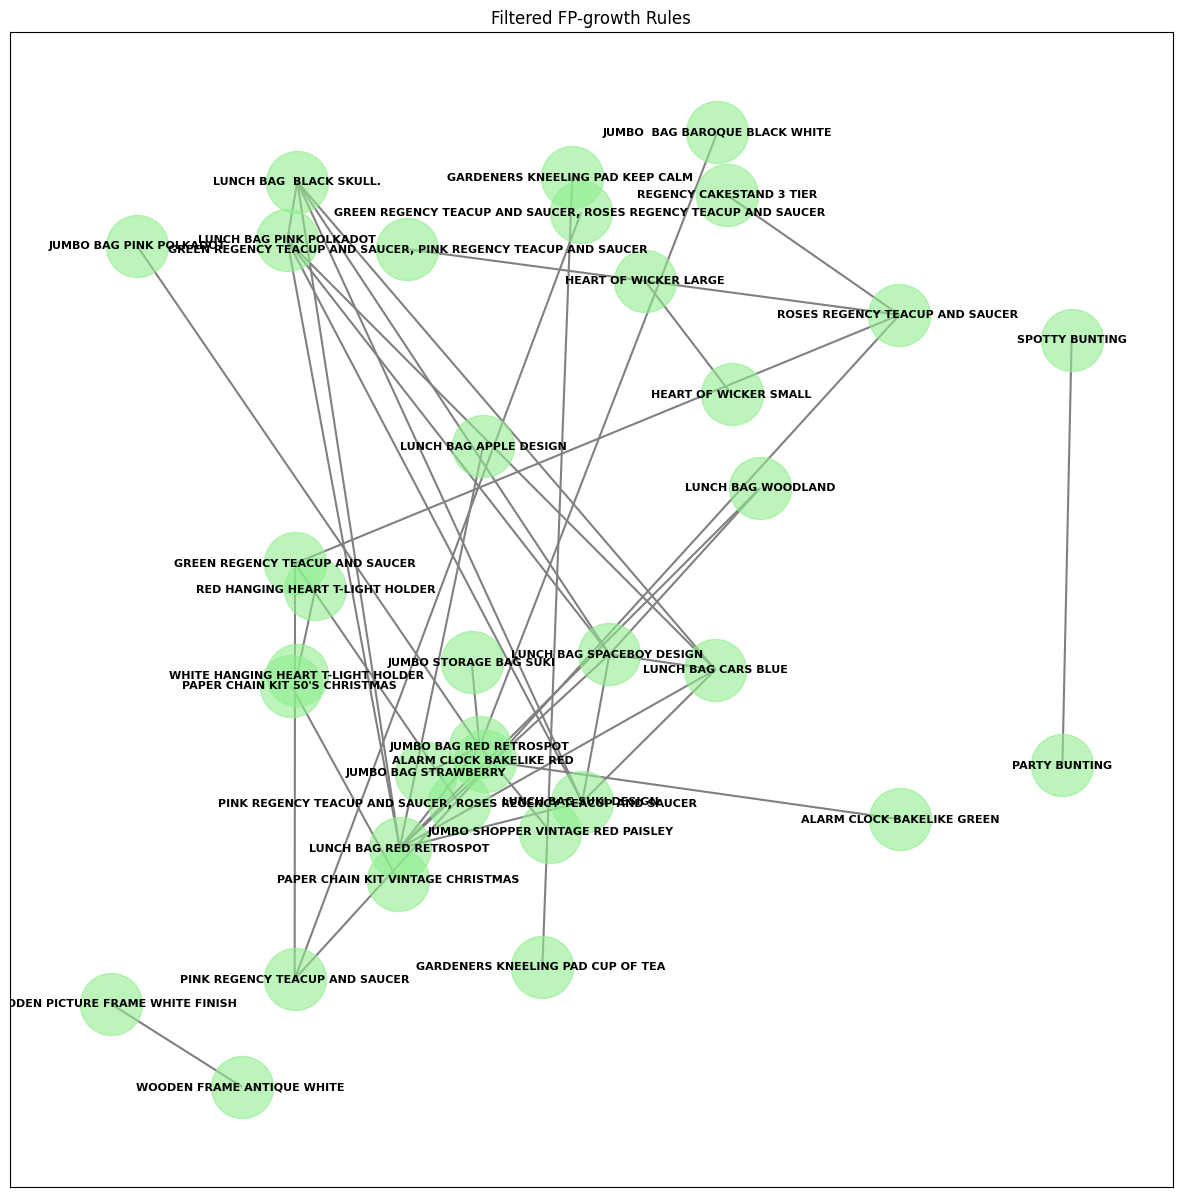

In [90]:
# Використовуємо дані правил FP-growth
rules_df_fp = filtered_rules_fp  # Припускаємо, що ви вже маєте ці дані після фільтрації

# Створюємо порожній граф
G_fp = nx.Graph()

# Додаємо вузли і з'єднання для кожного правила
for _, rule in rules_df_fp.iterrows():
    antecedent = ', '.join(sorted(rule['antecedents'])) if isinstance(rule['antecedents'], frozenset) else rule['antecedents']
    consequent = ', '.join(sorted(rule['consequents'])) if isinstance(rule['consequents'], frozenset) else rule['consequents']
    
    # Додаємо з'єднання між antecedent та consequent
    G_fp.add_edge(antecedent, consequent, weight=rule['lift'])  # Вага з'єднання - це lift

# Налаштовуємо візуалізацію з покращеним розташуванням
plt.figure(figsize=(15, 15))  # Збільшуємо розмір графіка для кращої видимості
pos_fp = nx.spring_layout(G_fp, k=0.005, iterations=1)  # Зменшуємо k для більшого простору між вузлами

# Рисуємо граф з покращеними параметрами
nx.draw_networkx_nodes(G_fp, pos_fp, node_size=2000, node_color="lightgreen", alpha=0.6)
nx.draw_networkx_edges(G_fp, pos_fp, width=1.5, edge_color='gray')  # Тонші лінії
nx.draw_networkx_labels(G_fp, pos_fp, font_size=8, font_weight="bold")

# Заголовок
plt.title("Filtered FP-growth Rules")
plt.show()


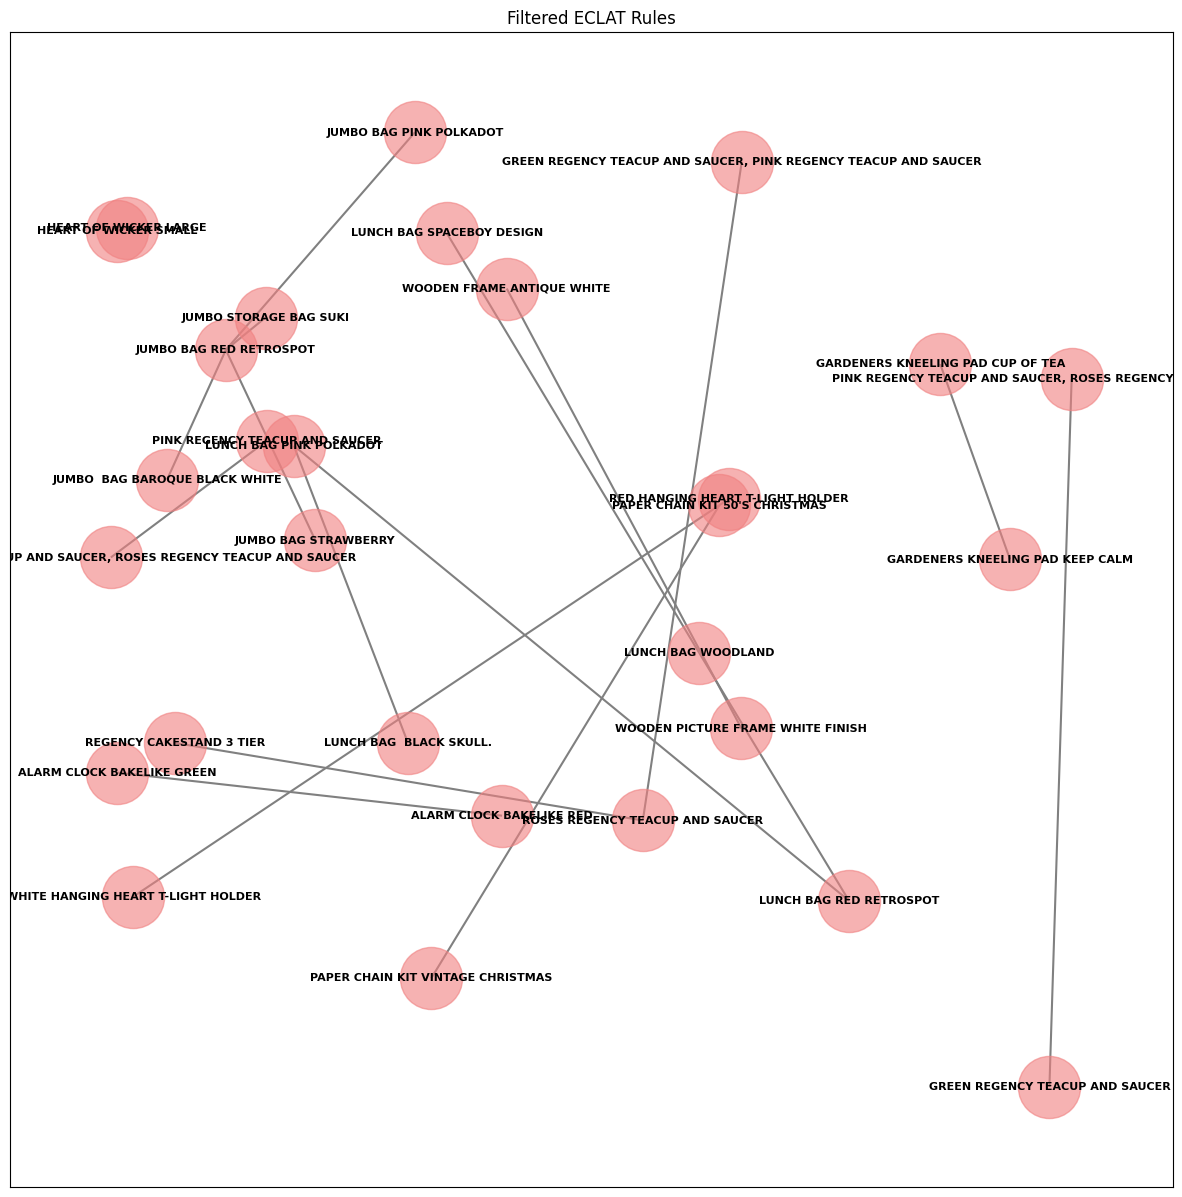

In [91]:
# Використовуємо дані правил ECLAT
rules_df_eclat = filtered_rules_eclat  # Припускаємо, що ви вже маєте ці дані після фільтрації

# Створюємо порожній граф
G_eclat = nx.Graph()

# Додаємо вузли і з'єднання для кожного правила
for _, rule in rules_df_eclat.iterrows():
    antecedent = ', '.join(sorted(rule['antecedent'].split(', '))) if isinstance(rule['antecedent'], str) else rule['antecedent']
    consequent = ', '.join(sorted(rule['consequent'].split(', '))) if isinstance(rule['consequent'], str) else rule['consequent']
    
    # Додаємо з'єднання між antecedent та consequent
    G_eclat.add_edge(antecedent, consequent, weight=rule['lift'])  # Вага з'єднання - це lift

# Налаштовуємо візуалізацію з покращеним розташуванням
plt.figure(figsize=(15, 15))  # Збільшуємо розмір графіка для кращої видимості
pos_eclat = nx.spring_layout(G_eclat, k=0.005, iterations=1)  # Зменшуємо k для більшого простору між вузлами

# Рисуємо граф з покращеними параметрами
nx.draw_networkx_nodes(G_eclat, pos_eclat, node_size=2000, node_color="lightcoral", alpha=0.6)
nx.draw_networkx_edges(G_eclat, pos_eclat, width=1.5, edge_color='gray')  # Тонші лінії
nx.draw_networkx_labels(G_eclat, pos_eclat, font_size=8, font_weight="bold")

# Заголовок
plt.title("Filtered ECLAT Rules")
plt.show()
